In [1]:
# 일부만 할당된 GPU 메모리를 실행하는 동안 필요한만큼 늘릴 수 있도록 설정함
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [2]:
# 모델 학습 시 불필요한 출력을 끄도록 함 (waning)

tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
import numpy as np

np.random.seed(777)

# 1. 데이터 준비

In [4]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
X_train.shape

(60000, 28, 28)

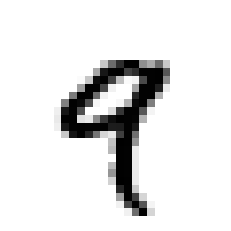

label:  9


In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

digit = X_train[4]
label = y_train[4]

plt.imshow(digit, cmap=plt.cm.binary)
plt.axis('off')
plt.show()
print('label: ', label)

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
print(y_test_5)

[False False False ... False  True False]


# 2. 데이터 전처리

In [9]:
X_train = X_train.reshape((60000, 28*28))
X_train = X_train.astype('float32') / 255

X_test = X_test.reshape((10000, 28*28))
X_test = X_test.astype('float32') / 255

# 3. 네트워크 정의 + 컴파일

In [10]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()

model.add(Dense(32, input_shape=(28*28,), activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# model.add(Dense(1, activation='softmax'))

model.compile(loss = 'binary_crossentropy', #'mse'
             optimizer = 'sgd',
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 26,209
Trainable params: 26,209
Non-trainable params: 0
_________________________________________________________________


Using TensorFlow backend.


# 4. 모델 학습

In [11]:
hist = model.fit(X_train, y_train_5, epochs=1)

Epoch 1/1
60000/60000 [==============================] - 7s 123us/step - loss: 0.1676 - acc: 0.9404


In [12]:
loss, acc = model.evaluate(X_train, y_train_5, verbose=0)
print(loss)
print(acc)

0.10070061321208874
0.96795


# 5. 분류 결과 분석

### - 혼동 행렬(confusion matrix)

In [13]:
from tensorflow.keras.utils import to_categorical

y_pred_5 = model.predict(X_test).ravel()
y_pred_5 = y_pred_5 > 0.5
print(y_pred_5)
print(y_test_5)

[False False False ... False False False]
[False False False ... False  True False]


In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_5, y_pred_5) # pred는 value로 전달
print(cm)

[[9056   52]
 [ 254  638]]


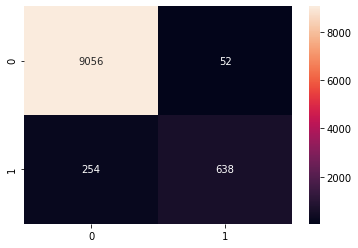

In [15]:
import pandas as pd
import seaborn as sns

df_cm = pd.DataFrame(cm)
heatmap = sns.heatmap(df_cm, annot=True, fmt='d')

In [16]:
import numpy as np

y_pred_5 = model.predict(X_test).ravel()

print(y_pred_5)
print(y_test_5)

[4.4708550e-03 9.2341185e-02 1.4815301e-02 ... 1.0697067e-02 4.1004911e-01
 2.9566884e-04]
[False False False ... False  True False]


### - Precision-Recall 커브(curve)

[0.10382959 0.10372526 0.10373734 ... 1.         1.         1.        ]
[1.         0.99887892 0.99887892 ... 0.00224215 0.00112108 0.        ]
[3.5053492e-04 3.5327673e-04 3.5354495e-04 ... 9.7586930e-01 9.7621214e-01
 9.7695190e-01]
8542
8542
8541
10000


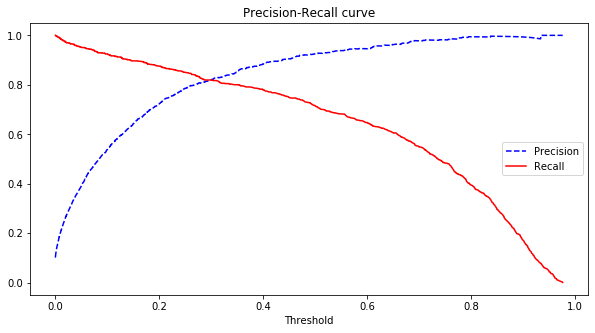

In [17]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test_5, y_pred_5) # pred 인자는 score(probability) 값으로 전달
print(precisions)
print(recalls)
print(thresholds)
print(len(precisions))
print(len(recalls))
print(len(thresholds))
print(len(y_test_5))

plt.figure(figsize=(10,5))
plt.title('Precision-Recall curve')
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'r-', label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.show()

### - ROC 커브(curve)

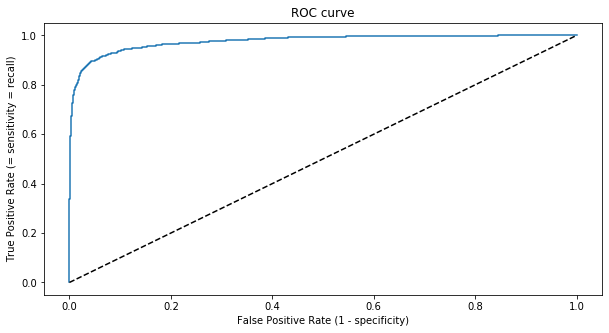

In [18]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_5, y_pred_5)

plt.figure(figsize=(10,5))
plt.title('ROC curve')
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], 'k--')
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.xlabel('False Positive Rate (1 - specificity)')
plt.ylabel('True Positive Rate (= sensitivity = recall)')
plt.show()

In [19]:
from sklearn.linear_model import Perceptron

perceptron = Sequential()
perceptron.add(Dense(1, input_shape=(28*28,), activation='sigmoid'))
perceptron.compile(optimizer='SGD', loss='binary_crossentropy', metrics=['acc'])
perceptron.fit(X_train, y_train_5,
              epochs = 1)

Epoch 1/1
60000/60000 [==============================] - 6s 92us/step - loss: 0.1959 - acc: 0.9263


In [20]:
y_perceptron = perceptron.predict(X_test)
print(y_perceptron)

[[0.02809548]
 [0.13481477]
 [0.05086687]
 ...
 [0.03361288]
 [0.15542746]
 [0.00223947]]


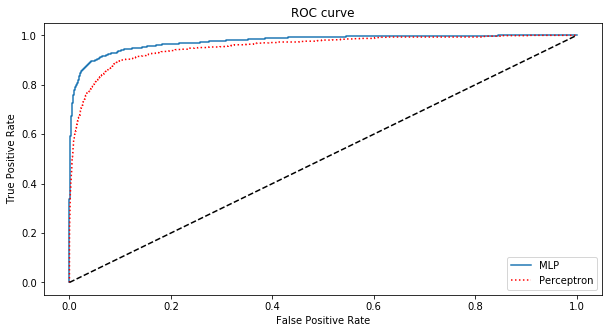

In [21]:
from sklearn.metrics import roc_curve

fpr1, tpr1, thresholds1 = roc_curve(y_test_5, y_pred_5)
fpr2, tpr2, thresholds2 = roc_curve(y_test_5, y_perceptron)

plt.figure(figsize=(10,5))
plt.title('ROC curve')
plt.plot(fpr1, tpr1, label='MLP')
plt.plot(fpr2, tpr2, 'r:', label='Perceptron')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import roc_auc_score

auc1 = roc_auc_score(y_test_5, y_pred_5)
auc2 = roc_auc_score(y_test_5, y_perceptron)
print('AUC of MLP :', auc1)
print('AUC of Perceptron :', auc2)

AUC of MLP : 0.9761143556839601
AUC of Perceptron : 0.9538754305582634
